# 3-Dimensional Representation of Anomaly Score

This program is meant to provide a 3-D representation of the anomaly score calculation. It generates several BMU (Best Matching Units) uniformly on $(0,1)^3$. Configurable Gaussian clusters are then generated randomly with each point within the cluster being paired to the nearest BMU. BMUs that do not pair with any clusters are not plotted. An anomaly score is calculated for each point in space and if the points anomaly score is in the 99$^{th}$ percentile, it is marked with a red x. 

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy.spatial.distance import cityblock
from scipy.spatial.distance import cosine
from scipy.spatial.distance import euclidean
import random
from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D

class Simulation(object):
    
    def __init__(self,minClusMean=0,maxClusMean=40,minClusStd=0.1,maxClusStd=10,
                    minClusSize=300,maxClusSize=400,numClus=5,numBMUs=20,
                    metric='cityblock',numSims=1):
        self.minClusMean=minClusMean
        self.maxClusMean=maxClusMean
        self.minClusStd=minClusStd
        self.maxClusStd=maxClusStd
        self.minClusSize=minClusSize
        self.maxClusSize=maxClusSize
        self.numClus=numClus
        self.numBMUs=numBMUs
        self.metric=metric
        self.numSims=numSims
        self.markerSize=10
    
    def getBMUs(self,numBMUs):
        BMUs=[]
        for x in range(1, numBMUs+1):
            x=np.random.uniform(0,self.maxClusMean)
            y=np.random.uniform(0,self.maxClusMean)
            z=np.random.uniform(0,self.maxClusMean)
            BMUs.append([x,y,z])
        return np.array(BMUs)
        
    def drawBMUs(self,ax, BMUs, BMUSizes):
        for value in BMUs:
            pointSize=(BMUSizes[str(value)]+1)*self.BMUScaleFactor
            if len(self.getBMUPoints(value)) != 0:
                ax.scatter(value[0], value[1], value[2], color='r',s=pointSize)

    def drawBMULines(self,ax, samples, BMUs, color):
        for point in samples:
            bmu=self.getClosestBMU(point, BMUs, self.metric)
            self.BMUSizes[str(bmu)]+=1
            ax.plot([point[0],bmu[0]],[point[1],bmu[1]], [point[2],bmu[2]], 
                     color=color, linestyle='-', linewidth=1)
      
    def getClosestBMU(self,point, BMUs, metric):
        minDist=np.inf
        minIndex=np.inf
        for index, bmu in enumerate(BMUs):
            if metric == 'cityblock':
                tmpDist=cityblock(point, bmu)
            if metric == 'cosine':
                tmpDist=cosine(point, bmu)       
            if metric == 'euclidean':
                tmpDist=euclidean(point, bmu)
            if tmpDist < minDist:
                minIndex=index
                minDist=tmpDist
        return np.array(BMUs[minIndex])
    
    def getDistance(self,point,BMU,metric):
        dist = getattr(sp.spatial.distance,metric)(point,BMU)
        return float(dist)/3
    
    def getClusPct(self,bmu):
        return self.BMUClusPcts.get(str(bmu))
    
    def getAnomScore(self,point,bmu,doPrint=False):
        #Given a vector and a BMU, we want to find the anom score.
        distance = self.getDistance(point,bmu,self.metric)
        y = 1 - self.getClusPct(bmu)
        anomSurface = 1.8*(distance - 0.5) * ((1-y)-0.5) + 0.5
        anomPlane = distance + y - 1
        if doPrint:
            print "1 - clusPct: %s" % y
            print "distance: %s" % distance
        if anomSurface > anomPlane:
            return anomSurface
        else:
            return anomPlane
        distance = self.getDistance(point,bmu,self.metric)
        return distance
    
    def resetSimulation(self):
        self.BMUSizes=defaultdict(int)
        self.BMUScaleFactor=10
        self.totalVectors=0
        self.clusters = []
    
    def getBMUPoints(self,BMU):
        # return a list of all the points associated with given BMU
        points = []
        for clus in self.clusters:
            for point in clus:
                if np.array_equal(BMU,self.getClosestBMU(point,self.BMUs,self.metric)):
                    points.append(point)
        return points
        
    def runSimulation(self):
        self.resetSimulation()
        
        for x in xrange(1,self.numSims+1):
            fig1 = plt.figure(figsize=(25, 18))
            ax = fig1.gca(projection='3d')
            plt.tight_layout()
    
            self.BMUs=self.getBMUs(self.numBMUs)
    
            #Create and plot the clusters
            for i in xrange(1,self.numClus+1):
                xCenter=random.uniform(self.minClusMean,self.maxClusMean)
                yCenter=random.uniform(self.minClusMean, self.maxClusMean)
                zCenter=random.uniform(self.minClusMean,self.maxClusMean)

                xSigma=random.uniform(self.minClusStd,self.maxClusStd)
                ySigma=random.uniform(self.minClusStd,self.maxClusStd)
                zSigma=random.uniform(self.minClusStd,self.maxClusStd)
                clusterSize=random.randint(self.minClusSize,self.maxClusSize)

                mu_vec1 = np.array([xCenter,yCenter,zCenter])
                cov_mat1 = np.array([[xSigma,0,0],[0,ySigma,0],[0,0,zSigma]])
    
                samples = np.random.multivariate_normal(mu_vec1, cov_mat1, 
                                                        clusterSize)
                self.clusters.append(samples)
                self.totalVectors+=len(samples)
                centroid=np.mean(samples, axis=0).reshape(1,3)
                self.drawBMULines(ax, samples, self.BMUs, '0.9')
                color=np.random.rand(3,1)
    
                #Plot clusters
                ax.scatter(samples[:,0], samples[:,1], samples[:,2], c=color, 
                           marker='+', s=self.markerSize, alpha=0.5)
                #Plot sample centroid
                ax.scatter(centroid[:,0], centroid[:,1], centroid[:,2], c=color, 
                          marker='+', s=self.markerSize*4, alpha=1.0,  linewidth='5')
                #Plot population centroid
                ax.scatter(mu_vec1[0], mu_vec1[1], mu_vec1[2], c=color, 
                          marker='+', s=self.markerSize*4, alpha=1.0,  linewidth='3')
                
            self.drawBMUs(ax,self.BMUs,self.BMUSizes)
            ax.set_xlim(self.minClusMean,self.maxClusMean)
            ax.set_ylim(self.minClusMean,self.maxClusMean)
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_zlabel('Z')
    
            # Calculate BMU ClusPct
            self.BMUClusPcts=dict.fromkeys(self.BMUSizes.keys())
            for bmu,size in self.BMUSizes.iteritems():
                self.BMUClusPcts[str(bmu)] = float(size)/self.totalVectors
            
            print "%s total vectors generated: " % self.totalVectors
            
            # Find anomScores for the points
            for bmu in self.BMUs:
                bmuPoints = self.getBMUPoints(bmu)
                print "Processing BMU %s:" % str(bmu)
                print "Vectors belonging to current BMU: %s " % len(bmuPoints)
                print "BMU cluster percent: %s" % self.BMUClusPcts[str(bmu)]
                #Get anom score for all points associated with BMU
                bmuAnoms = []
                for point in bmuPoints:
                    bmuAnoms.append(self.getAnomScore(point,bmu)) #collect all the anom scores
                anoms=0
                for point in bmuPoints:
                    if self.getAnomScore(point,bmu) > np.percentile(bmuAnoms,99): #check if score is in 99th percentile
                        ax.scatter(point[0],point[1],point[2], c='red',
                            marker='x', s=100, alpha=1)
                        anoms = anoms + 1
                print "Found %s anomalies\n" % anoms
            plt.show()

### To Run

First create a new simulation

In [36]:
s = Simulation(numClus=1,minClusMean=0,maxClusMean=1,minClusStd=0.001,maxClusStd=0.005,minClusSize=600,maxClusSize=1000)

Now run the simulation. This will produce a graphic in which highly anomalous points are colored red. It also prints BMU information to the console. 

764 total vectors generated: 
Processing BMU [ 0.71244879  0.94217232  0.95113436]:
Vectors belonging to current BMU: 0 
BMU cluster percent: 0.0
Found 0 anomalies

Processing BMU [ 0.52016641  0.06276601  0.29677407]:
Vectors belonging to current BMU: 0 
BMU cluster percent: 0.0
Found 0 anomalies

Processing BMU [ 0.86485801  0.79012515  0.35348493]:
Vectors belonging to current BMU: 5 
BMU cluster percent: 0.0065445026178
Found 1 anomalies

Processing BMU [ 0.93586628  0.43163326  0.49988313]:
Vectors belonging to current BMU: 83 
BMU cluster percent: 0.108638743455
Found 1 anomalies

Processing BMU [ 0.26736852  0.36221362  0.37155018]:
Vectors belonging to current BMU: 0 
BMU cluster percent: 0.0
Found 0 anomalies

Processing BMU [ 0.2155578   0.72242336  0.32256457]:
Vectors belonging to current BMU: 0 
BMU cluster percent: 0.0
Found 0 anomalies

Processing BMU [ 0.490243    0.52789252  0.36130782]:
Vectors belonging to current BMU: 457 
BMU cluster percent: 0.598167539267
Found 5

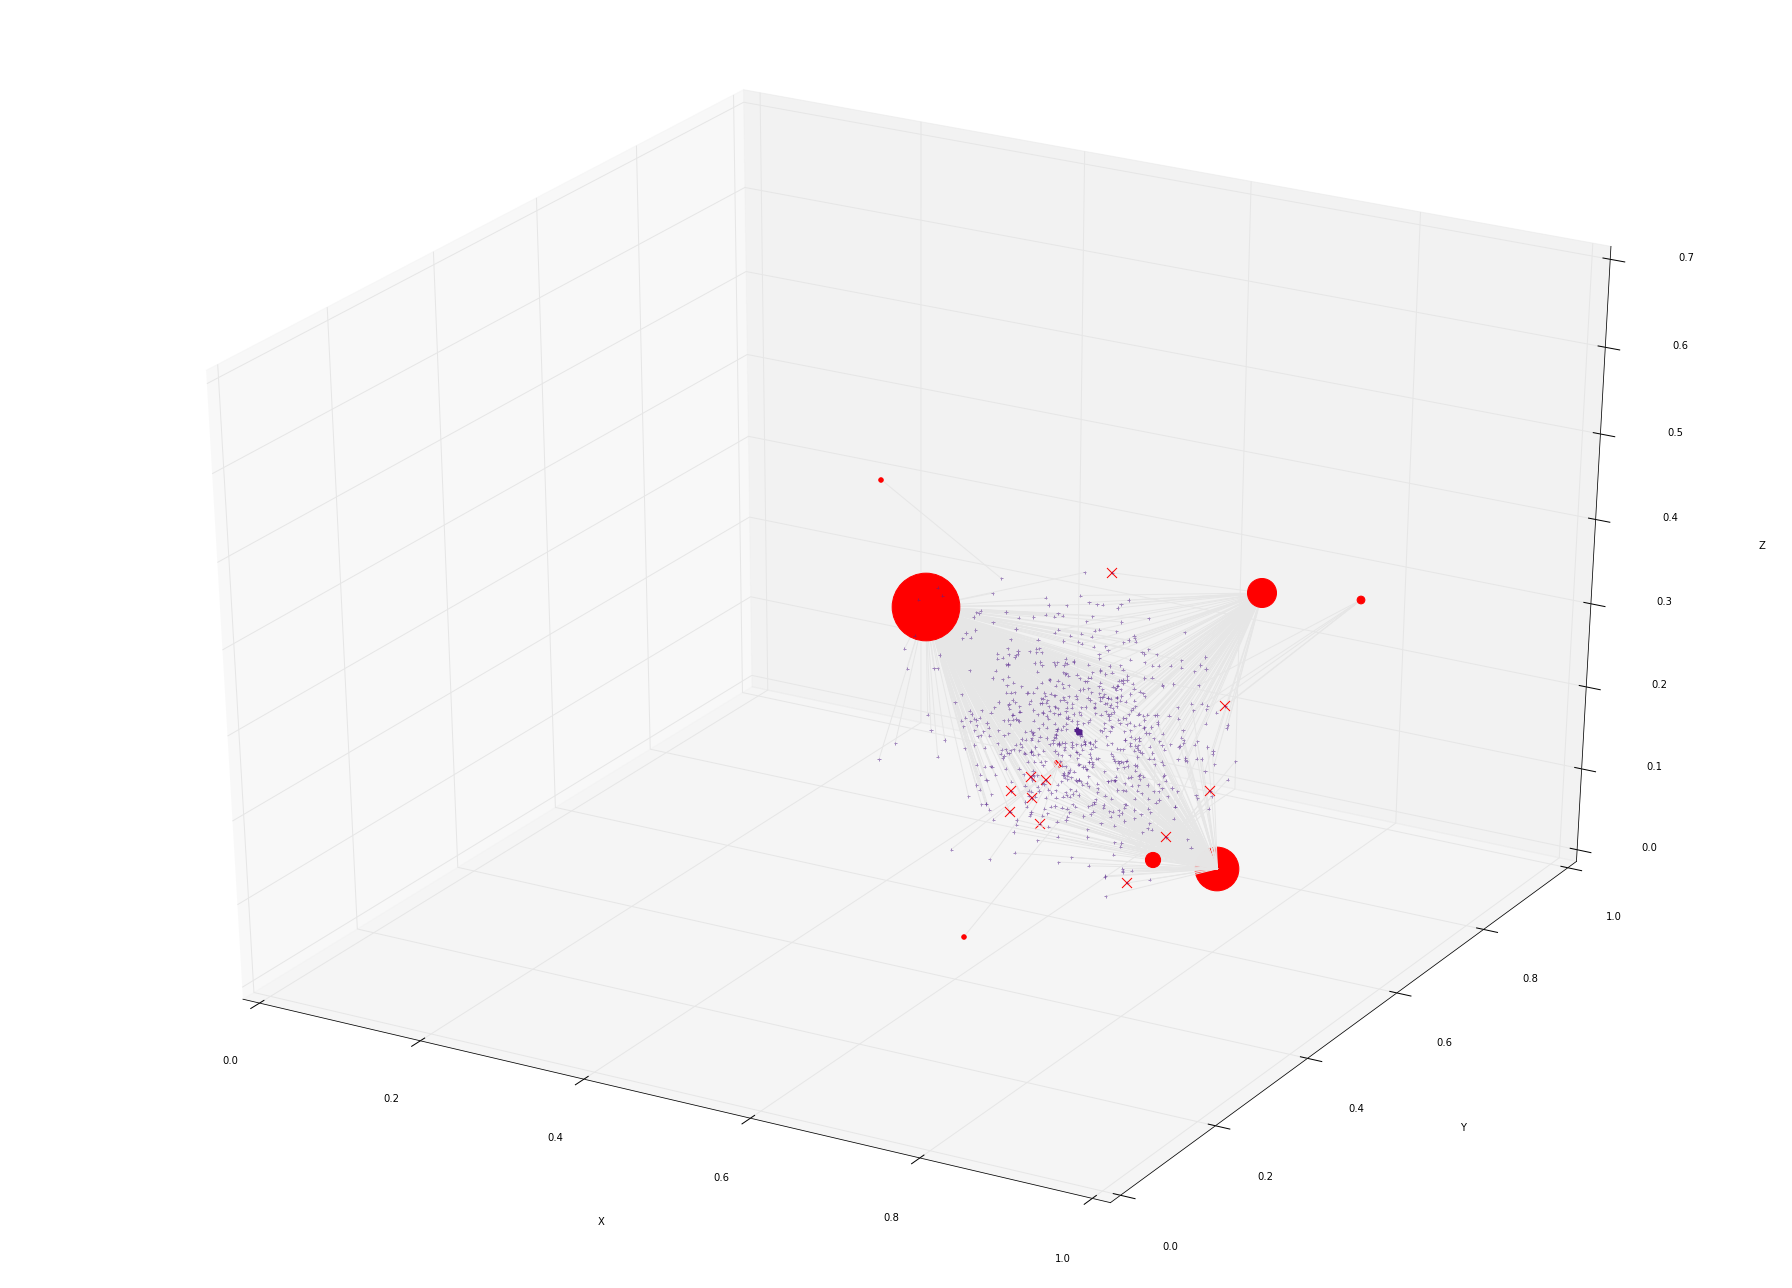

In [37]:
s.runSimulation()